# Feature Engineering

In [1]:
import re

import pandas as pd
import numpy as np

import scipy as sp
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = [10,5]

In [2]:
train = pd.read_csv("../data/train/train.csv")
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [3]:
def count_overview(variable, title):
    plt.figure(figsize=(10,4))
    ax = sns.barplot(x=variable, y = variable.index, palette="Spectral")
    ax.set_title(title)
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

def stacked_barplot(tab, title):
    tab_percent = tab.apply(lambda r: r/r.sum(), axis=1)
    ax = tab_percent.plot.barh(stacked=True, cmap='Spectral', alpha=0.8)
    ax.set_title(title)
    vals = ax.get_yticks()
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=5)
    plt.tight_layout()
    plt.show()

### Name or Not

* The only variable with missing values is the "Name". 
* My intuition is that people are more likely to respond positively to listed pets with existing names. Imagine a little girl saying:
    * "Aww, look how cute '*Peanut*' is!"

Let's test the hypothesis that the name would play a role in the Adoption Speed. First, we define a new variable ("NameorNot"), then conduct a chi-squared enrichment analysis. Lastly, we examine the standardized residuals to see any effects.

Number of Animals by Type


AdoptionSpeed,0,1,2,3,4
NameorNot,,,,,
Has a Name,384,2819,3725,3043,3765
No Name,26,271,312,216,432


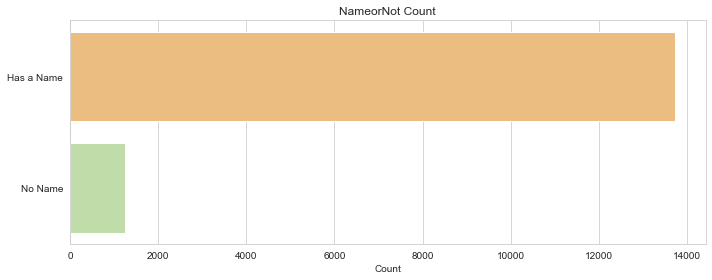

Chi-Square Test of Independence: p-value = 1.076E-07


AdoptionSpeed,0,1,2,3,4
NameorNot,,,,,
Has a Name,1.513055,-0.869614,1.757704,4.0889,-5.259132
No Name,-1.513055,0.869614,-1.757704,-4.0889,5.259132


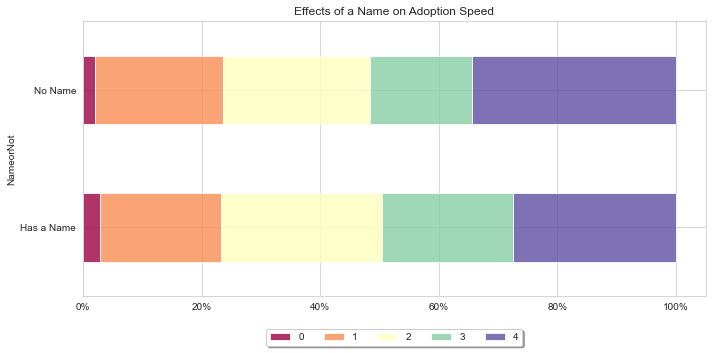

In [15]:
train['NameorNot'] = np.where(train['Name'].isnull(), 'No Name', 'Has a Name')

name_or_not = train.groupby(['NameorNot', 'AdoptionSpeed']).size().reset_index().pivot(
    columns='AdoptionSpeed', index='NameorNot', values=0)
print("Number of Animals by Type")
display(name_or_not)

ggDF = train['NameorNot'].value_counts()
count_overview(ggDF, 'NameorNot Count')

tab = pd.crosstab(train['NameorNot'], train['AdoptionSpeed'])
table = sm.stats.Table(tab)

print("Chi-Square Test of Independence: p-value = {:.3E}".format(sp.stats.chi2_contingency(tab)[1]))
display(table.standardized_resids)

stacked_barplot(tab, "Effects of a Name on Adoption Speed")
plt.show()

Looking at the standardized residuals table and the bottom plot, we can see that pets that are listed without a name are more likely to NOT be adopted (Adoption Speed = 4).

* As a rule of thumb, values outside the range of [-2, 2] exhibit a lower or higher than expected frequency, respectively.

In [18]:
# list(train.Name)
    # Replace No Name Yet as nan
    # 

In [42]:
# Strange Names (Regex Pattern Search)
pattern = re.compile(r"[0-9\.:!]")
data_df = train.copy(deep=True)
data_df['Name'] = data_df['Name'].fillna('')
data_df['strange_name'] = data_df['Name'].apply(lambda x: len(pattern.findall(x))>0).astype(np.int8)
data_df['yval'] = 1

Number of Animals by Type


AdoptionSpeed,0,1,2,3,4
strange_name,,,,,
0,381,2729,3621,2907,3832
1,29,361,416,352,365


Chi-Square Test of Independence: p-value = 9.878E-05


AdoptionSpeed,0,1,2,3,4
strange_name,,,,,
0,2.096569,-3.148876,-0.360711,-1.373043,3.693193
1,-2.096569,3.148876,0.360711,1.373043,-3.693193


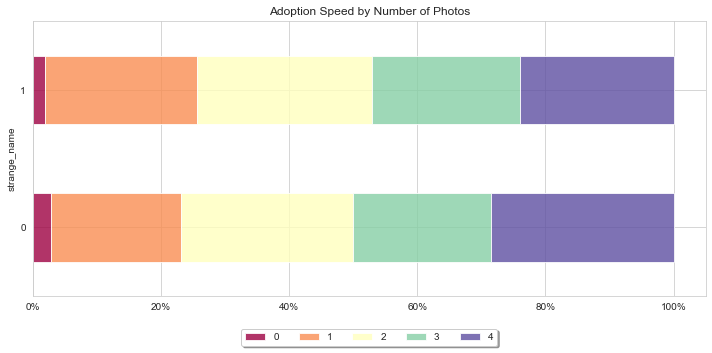

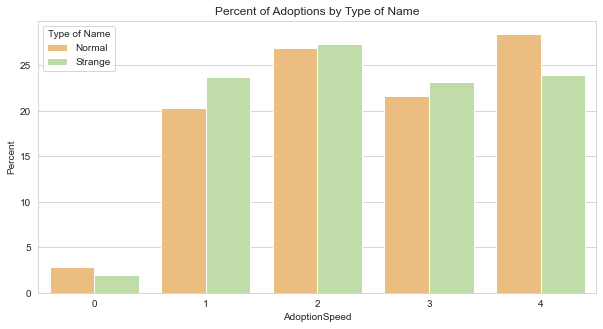

In [107]:
strange_names = data_df[data_df['strange_name']!= 0]
normal_names = data_df[data_df['strange_name'] == 0]

strange_or_normal = data_df.groupby(['strange_name', 'AdoptionSpeed']).size().reset_index().pivot(
    columns='AdoptionSpeed', index='strange_name', values=0)
print("Number of Animals by Type")
display(strange_or_normal)

ggDF = data_df['strange_name'].value_counts()
tab = pd.crosstab(data_df['strange_name'], data_df['AdoptionSpeed'])
table = sm.stats.Table(tab)
print("Chi-Square Test of Independence: p-value = {:.3E}".format(sp.stats.chi2_contingency(tab)[1]))
display(table.standardized_resids)
stacked_barplot(tab, "Adoption Speed by Number of Photos")
plt.show()

ggDF = pd.DataFrame([normal_names['AdoptionSpeed'].value_counts()/(normal_names.shape[0])*100, 
              strange_names['AdoptionSpeed'].value_counts()/(strange_names.shape[0])*100]).transpose()
ggDF.columns = ['Normal', 'Strange']
ggDF = ggDF.melt()
ggDF['AdoptionSpeed'] = np.resize([0,1,2,3,4], 10)
ggDF.columns = ['Type of Name', 'Percent', 'AdoptionSpeed']
sns.barplot(data=ggDF, x='AdoptionSpeed',y='Percent', hue='Type of Name', palette='Spectral').set_title("Percent of Adoptions by Type of Name")
plt.show()

name_len                                                
                 count      mean       std  min  25%  50%    75%   max
AdoptionSpeed                                                         
0                410.0  9.282927  7.901778  0.0  5.0  6.0  11.75  35.0
1               3090.0  8.727832  7.318586  0.0  4.0  6.0  11.00  44.0
2               4037.0  8.653951  7.265828  0.0  4.0  6.0  11.00  45.0
3               3259.0  8.881866  7.619390  0.0  5.0  6.0  11.00  47.0
4               4197.0  8.574220  7.454727  0.0  4.0  6.0  11.00  40.0

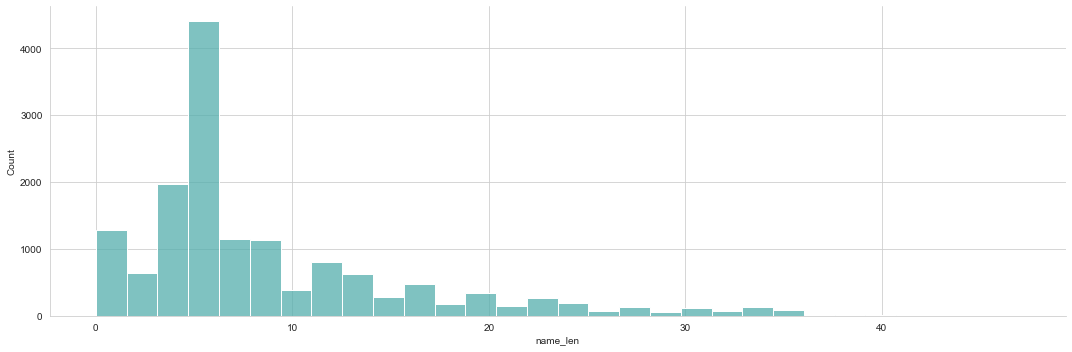

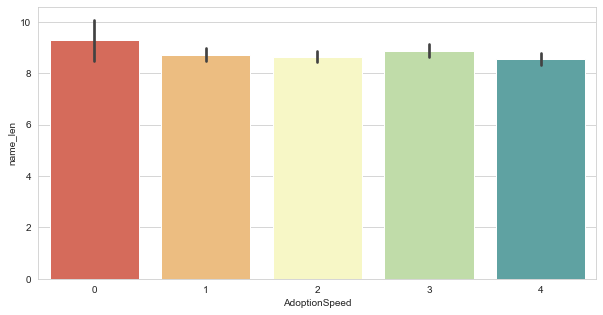

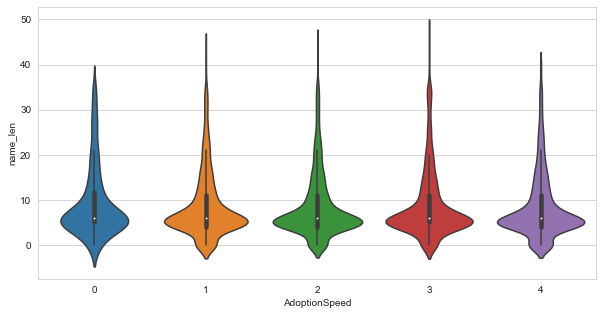

In [95]:
# Name Length
data_df['name_len'] = data_df['Name'].apply(lambda x: len(x))
display(data_df[['AdoptionSpeed', 'name_len']].groupby('AdoptionSpeed').describe())

ax = sns.displot(data_df['name_len'], kde=False, bins=30, color=sns.color_palette("Spectral", 5)[4], aspect=3)
ax.set_titles("Name Length")
plt.show()

sns.barplot(x=data_df.AdoptionSpeed, y=data_df.name_len, palette = 'Spectral')
plt.show()

sns.violinplot(x=data_df['AdoptionSpeed'], y=data_df['name_len'])
plt.show()

### Age (In Years)

Absolute Counts -  AdoptionSpeed vs Age in Years  
  



Age,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,19,21
AdoptionSpeed,,,,,,,,,,,,,,,,,,,
0,297,57,24,9,5,6,6,1,3,1,1,0,0,0,0,0,0,0,0
1,2494,223,132,87,62,49,9,15,8,4,5,1,1,0,0,0,0,0,0
2,3275,314,133,93,69,57,39,31,11,4,8,1,1,1,0,0,0,0,0
3,2516,289,176,83,50,53,31,33,11,4,4,4,1,0,1,1,2,0,0
4,2662,674,352,212,114,58,40,32,15,11,17,3,2,0,0,1,1,1,2


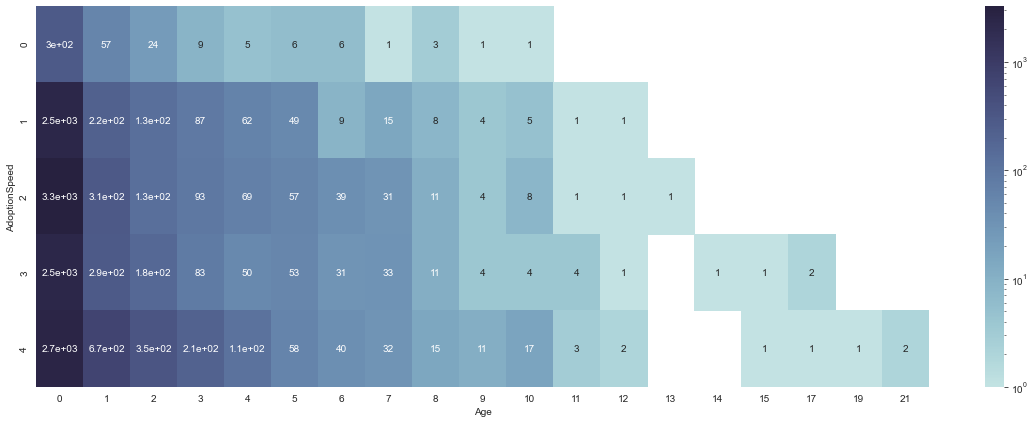

In [36]:
age_yrs = pd.DataFrame([train['Age']//12, train['AdoptionSpeed']]).transpose()
age_yrs['Value'] = 1
age_yrs = age_yrs.groupby(['Age','AdoptionSpeed']).sum()

age_yrs_pivot = pd.pivot_table(age_yrs, values='Value', index='AdoptionSpeed', columns='Age').fillna(0).astype('int64')
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

print('Absolute Counts -  AdoptionSpeed vs Age in Years  \n  \n')
plt.figure(figsize=(20,7))
display(age_yrs_pivot)
sns.heatmap(age_yrs_pivot, norm=LogNorm(), cmap=cmap, annot=True)
plt.show()

Relative Percent -  AdoptionSpeed vs Age in Years  
  



Age,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,19,21
AdoptionSpeed,,,,,,,,,,,,,,,,,,,
0,2,3,2,1,1,2,4,0,6,4,2,0,0,0,0,0,0,0,0
1,22,14,16,17,20,21,7,13,16,16,14,11,20,0,0,0,0,0,0
2,29,20,16,19,23,25,31,27,22,16,22,11,20,100,0,0,0,0,0
3,22,18,21,17,16,23,24,29,22,16,11,44,20,0,100,50,66,0,0
4,23,43,43,43,38,26,32,28,31,45,48,33,40,0,0,50,33,100,100


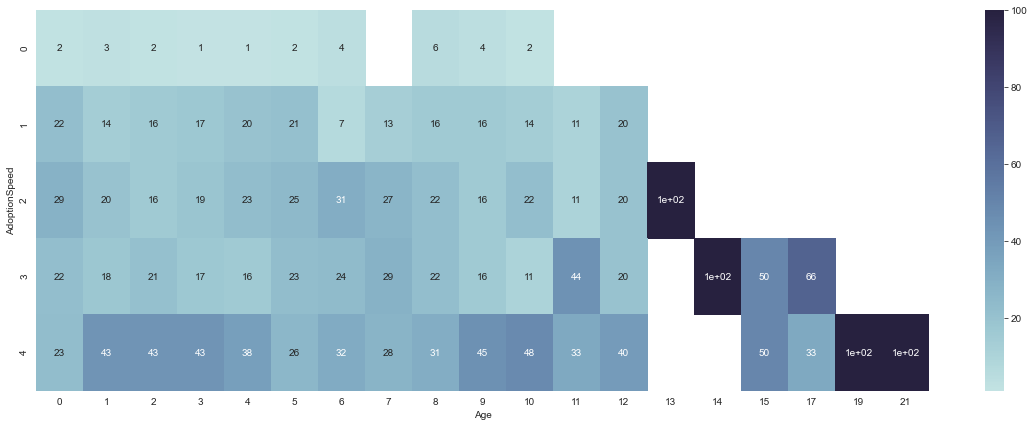

In [37]:
print('Relative Percent -  AdoptionSpeed vs Age in Years  \n  \n')

age_pivot_pct = (age_yrs_pivot.div(age_yrs_pivot.sum(axis=0), axis=1)*100).astype('int64')


display(age_pivot_pct)
plt.figure(figsize=(20,7))
sns.heatmap(age_pivot_pct.replace(['0', 0], np.nan), cmap=cmap, annot=True)
plt.show()